In [ ]:
!pip install PyPDF2

     |████████████████████████████████| 77 kB 3.2 MB/s 
  Created wheel for PyPDF2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61101 sha256=08f6c9dbafc61f2bdd48909ba6f65887804f512affcb21597cbc916306309798
  Stored in directory: /root/.cache/pip/wheels/80/1a/24/648467ade3a77ed20f35cfd2badd32134e96dd25ca811e64b3
Successfully built PyPDF2


In [ ]:
!pip install geonamescache 
import geonamescache

gc = geonamescache.GeonamesCache()


     |████████████████████████████████| 2.6 MB 5.2 MB/s 


In [ ]:
!pip install unidecode
import re
from unidecode import unidecode

     |████████████████████████████████| 235 kB 5.4 MB/s 


# Loading Headline Data

In [ ]:
headlines_file = open('Headlines.txt','r')
headlines =[line.strip()\
    for line in headlines_file.readlines()] 
num_headlines = len(headlines)
print(f'{num_headlines} headlines have been loaded')

453 headlines have been loaded


# Converting names to regexes

In [ ]:
def name_to_regex(name):
    decoded_name = unidecode(name)
    if name != decoded_name:
        regex = fr'\b({name}|{decoded_name})\b'
    else:
        regex = fr'\b{name}\b'
    return re.compile(regex,flags = re.IGNORECASE)

# Mapping names to regex

In [ ]:
# mapping to regex
countries = [country['name']
             for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name for name in countries}
cities = [city['name']
          for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

# Finding locations in text

In [ ]:
def get_name_in_text(text, dictionary):
    for regex, name in sorted(dictionary.items(),
                              key=lambda x:x[1]):
        if regex.search(text):
            return name
    return None

# Finding locations in headlines


In [ ]:
import pandas as pd

matched_countries = [get_name_in_text(headline,country_to_name)
    for headline in headlines]
matched_cities = [get_name_in_text(headline,city_to_name)
                     for headline in headlines]
data = {'Headline': headlines, 'City': matched_cities,
        'Country': matched_countries}
df = pd.DataFrame(data)

# Summarizing the location data:

In [ ]:
summary = df[['City','Country']].describe()
print(summary)

       City   Country
count   411        15
unique  347        10
top      Of  Malaysia
freq     29         3


# Fetching cities named "of":

In [ ]:
of_cities = df[df['City']=='Of'][['City','Headline']]
ten_of_cities = of_cities.head(10)
print(ten_of_cities.to_string(index=False))

City                                                                                        Headline
  Of                                                           Case of Measles Reported in Vancouver
  Of                         Authorities are Worried about the Spread of Bronchitis in Silver Spring
  Of                             Authorities are Worried about the Spread of Mad Cow Disease in Rome
  Of                               Authorities are Worried about the Spread of Influenza in Savannah
  Of  The Spread of Measles in Spokane has been Confirmed Zika alert for Rio Grande Valley residents
  Of                                           Authorities are Worried about the Spread of Dengue in
  Of  Urbana Encounters Severe Symptoms of Meningitis Pittsburgh Residents Recieve Norovirus vaccine
  Of                                                                Outbreak of Zika in Stephenville
  Of         Providence Encounters Severe Symptoms of Dengue Tests negative on Windsor Zika

# Finding Multicity headlines


In [ ]:
def get_cities_in_headline(headline):
    cities_in_headline = set()
    for regex, name in city_to_name.items():
        match = regex.search(headline)
        if match:
            if headline[match.start()].isupper():
                cities_in_headline.add(name)
    return list(cities_in_headline)

df['Cities'] = df['Headline'].apply(
    get_cities_in_headline
)
df['Num_Cities'] = df['Cities'].apply(len)
df_multiple_cities = df[df['Num_Cities'] > 1]
num_rows, _ = df_multiple_cities.shape
print(f'{num_rows} headlines match multiple cities')


208 headlines match multiple cities


# Sampling Multicity headlines:

In [ ]:
ten_cities = df_multiple_cities[['Cities','Headline']].head(10)
print(ten_cities.to_string(index=False))

                                    Cities                                                                                            Headline
 [New York City, Miami Beach, Miami, York]                                   Could Zika Reach New York City? First Case of Zika in Miami Beach
                [Recife, Dallas, Trinidad]   Mystery Virus Spreads in Recife, Brazil Dallas man comes down with case of Zika Trinidad confirms
                [Houston, Genève, Atlanta]  Zika Concerns are Spreading in Houston Geneve Scientists Battle to Find Cure The CDC in Atlanta is
                  [São Paulo, Brownsville]            Growing Worried Zika Infested Monkeys in Sao Paulo Brownsville teen contracts Zika virus
                [San Juan, San, Galveston]         San Juan reports 1st U.S. Zika-related death amid outbreak Flu outbreak in Galveston, Texas
                          [Manila, Iloilo]                                   Zika alert — Manila now threatened Zika afflicts 7 in Iloilo City

# Selecting the longest city names:

In [ ]:
def get_longest_city(cities):
    if cities:
        return max(cities, key=len)
    return None

df['City'] = df['Cities'].apply(get_longest_city)

# Printing the Shortest City Name:

In [ ]:
short_cities = df[df['City'].str.len() <=4][['City','Headline']]
print(short_cities.to_string(index=False))

 City                                                             Headline
 Rome  Authorities are Worried about the Spread of Mad Cow Disease in Rome
 Baud                                            in Baud have been Refuted
 Kobe                                       Chikungunya re-emerges in Kobe
 Bonn                    Contaminated Meat Brings Trouble for Bonn Farmers
 Yuma                                         Zika seminars in Yuma County
 Lyon                                     Mad Cow Disease Detected in Lyon
 Yiwu      Authorities are Worried about the Spread of Hepatitis B in Yiwu


# Fetching Headlines with Countries:

In [ ]:
df_countries = df[df['Country'].notnull()][['City',
                                            'Country',
                                            'Headline']]
print(df_countries.to_string(index=False))

             City    Country                                                                                           Headline
         Trinidad     Brazil  Mystery Virus Spreads in Recife, Brazil Dallas man comes down with case of Zika Trinidad confirms
 Ho Chi Minh City    Vietnam                 Zika cases in Vietnam's Ho Chi Minh City surge Philadelphia experts track pandemic
        San Diego   Thailand     Scientists in Paris to look for answers Key Zika Findings in San Diego Institute Thailand-Zika
       Piracicaba     Brazil                            Zika outbreak in Piracicaba, Brazil Lima tries to address Zika Concerns
     Fort Collins   Malaysia              Fort Collins Encounters Severe Symptoms of Gonorrhea Zika surfaces in Klang, Malaysia
   Guatemala City  Guatemala                              Rumors about Meningitis spreading in Guatemala City have been refuted
     Hillsborough     Belize   Hillsborough uses innovative trap against Zika 20 minutes ago Belize City

In [ ]:
# dropping the countries from table

df.drop('Country', axis=1, inplace=True)

# Exploring unmatched headlines

In [ ]:
df_unmatched = df[df['City'].isnull()]
num_unmatched = len(df_unmatched)
print(f'{num_unmatched} headlines contain no city matched.')
print(df_unmatched.head(10)[['Headline']].values)

49 headlines contain no city matched.
[['first Zika case']
 ['Zika threat']
 ['']
 ['Mandatory']
 ['']
 ['Maka City Experiences Influenza Outbreak']
 ['Zika case']
 ['']
 ['']
 ['Authorities are Worried about the Spread of Dengue in']]


In [ ]:
# Dropping the unmatched headlines
df = df[~df['City'].isnull()][['City', 'Headline']]

# Assigning the Geographic coordinates to cities:

In [ ]:
latitudes , longitudes = [], []
for city_name in df['City'].values:
    city = max(gc.get_cities_by_name(city_name),
               key=lambda x: list(x.values())[0]['population'])
    city = list(city.values())[0]
    latitudes.append(city['latitude'])
    longitudes.append(city['longitude'])

df = df.assign(Latitude=latitudes, Longitude=longitudes)

# Plotting a geographical elbow curve

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

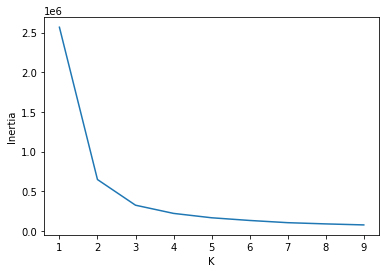

In [ ]:
coordinates = df[['Latitude','Longitude']].values
k_values = range(1,10)
inertia_values = []
for k in k_values:
    inertia_values.append(KMeans(k).fit(coordinates).inertia_)

plt.plot(range(1,10), inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

# Defining a NumPy based great-circle metric

In [ ]:
import numpy as np
from math import sin, cos, asin

def great_circle_distance(coord1, coord2,
                          radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0
    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = sin(delta_x/2)**2 + np.product(
        [cos(coord1[0]),
         cos(coord2[0]),
         sin(delta_y/2)**2]
    )
    return 2 * radius * asin(haversin **0.5)

# using DBSCAN to clsuter cities

In [ ]:
from sklearn.cluster import DBSCAN

metric = great_circle_distance
db = DBSCAN(eps=250, min_samples=3, metric=metric)
df['Cluster'] = db.fit_predict(coordinates)

# Assigning Country codes to cities

In [ ]:
def get_country_code(city_name):
    city = max(gc.get_cities_by_name(city_name),
               key=lambda x: list(x.values())[0]['population'])
    return list(city.values())[0]['countrycode']

df['Country_code'] = df['City'].apply(get_country_code)

In [ ]:
df.head()

,City,Headline,Latitude,Longitude,Cluster,Country_code
0,Miami,Zika Outbreak Hits Miami,25.77427,-80.19366,0,US
1,New York City,Could Zika Reach New York City? First Case of ...,40.71427,-74.00597,0,US
2,Trinidad,"Mystery Virus Spreads in Recife, Brazil Dallas...",-14.83333,-64.90000,-1,BO
4,Houston,Zika Concerns are Spreading in Houston Geneve ...,29.76328,-95.36327,0,US
5,Brownsville,Growing Worried Zika Infested Monkeys in Sao P...,25.90175,-97.49748,0,US


In [ ]:
df_us = df[df['Country_code']=='US']
df_not_us = df[df['Country_code'] != 'US']

In [ ]:
def re_cluster(input_df, eps):
    input_coord = input_df[['Latitude',
                            'Longitude']].values
    db = DBSCAN(eps=eps, min_samples=3,
                metric=great_circle_distance)
    clusters = db.fit_predict(input_coord)
    input_df = input_df.assign(Cluster=clusters)
    return input_df[input_df['Cluster']> -1]

df_not_us = re_cluster(df_not_us, 250)
df_us = re_cluster(df_us,125)

In [ ]:
groups = df_not_us.groupby('Cluster')
num_groups = len(groups)
print(f'{num_groups} Non-US clusters have been detected')


20 Non-US clusters have been detected


In [ ]:
sorted_groups = sorted(groups, 
                       key=lambda x: len(x[1]),
                       reverse=True)
group_id, largest_group = sorted_groups[0]
group_size = len(largest_group)
print(f'Largest cluster contains {group_size} headlines')

Largest cluster contains 32 headlines


# Computing the Cluster Centrality:

In [ ]:
def compute_centrality(group):
    group_coords = group[['Latitude',
                          'Longitude']].values
    center = group_coords.mean(axis=0)
    distance_to_center = [great_circle_distance
                          (center, coord) 
                          for coord in group_coords]
    group['Distance_to_center'] = distance_to_center

# Finding the central headlines in the Largest cluster

In [ ]:
def sort_by_centrality(group):
    compute_centrality(group)
    return group.sort_values(by=['Distance_to_center'],
                             ascending=True)

largest_group = sort_by_centrality(largest_group)    
for headline in largest_group['Headline'].values[:5]:
    print(headline)


More Livestock in Fontainebleau are infected with Mad Cow Disease
Scranton authorities confirmed the spread of Gonorrhea Mad Cow Disease Disastrous to Brussels
Milwaukee authorities confirmed the spread of Rhinovirus Mad Cow Disease Hits Rotterdam
Contaminated Meat Brings Trouble for Bonn Farmers
Case of Mad Cow Disease Reported in Hilden


# Finding the top 3 countries in the largest cluster

In [ ]:
from collections import Counter

def top_countries(group):
    countries = [gc.get_countries()[country_code]['name']
                 for country_code in group['Country_code'].values]
    return Counter(countries).most_common(3)

print(top_countries(largest_group))

[('United Kingdom', 11), ('France', 4), ('Germany', 4)]


# Summarizing content in the largest clusters:

In [ ]:
for _, group in sorted_groups[1:5]:
    sorted_group = sort_by_centrality(group)
    print(top_countries(sorted_group))
    for headline in sorted_group['Headline'].values[:5]:
        print(headline)
    print('\n')

[('Thailand', 5), ('Cambodia', 2), ('Vietnam', 1)]
Chanthaburi
Virus in Bangkok
How to Avoid Contaminated Meat when Visiting Basel More Zika patients reported in Kampong Speu
Herpes Keeps Spreading in Rochester Zika case reported in Phetchabun
Zika Troubles come to Kampong Cham Zika case reported in Rizal


[('Colombia', 7)]
Zika spreads to Caucasia
Zika symptoms spotted in Bello
Zika case reported in Medellin
Zika Outbreak in Sincelejo
18 new Zika Cases in Bogota Spanish Flu Sighted in Antigua


[('Philippines', 6)]
More Zika patients reported in Camacari Outbreak of Zika in Pasig City
More Zika patients reported in Calumpang Zika symptoms spotted in Quisqueya
New Vaccine on Trial in Bethesda District Townsville Zika tests inconclusive Mandaluyong City under
More Quezon City Zika Transmissions
Antipolo under threat from Zika Virus Spreading Zika reaches Bacoor


[('El Salvador', 3), ('Guatemala', 1), ('Honduras', 1)]
Student sick in Campinas, Brazil More Zika cases in Soyapango
How to

# Summarizing Content within the largest US Clusters:

In [ ]:
us_groups = df_us.groupby('Cluster')
us_sorted_groups = sorted(us_groups,
                          key=lambda x: len(x[1]),
                          reverse=True)
for _, group in sorted_groups[:5]:
    sorted_group = sort_by_centrality(group)
    for headline in sorted_group['Headline'].values[:5]:
        print(headline)
    print('\n')

More Livestock in Fontainebleau are infected with Mad Cow Disease
Scranton authorities confirmed the spread of Gonorrhea Mad Cow Disease Disastrous to Brussels
Milwaukee authorities confirmed the spread of Rhinovirus Mad Cow Disease Hits Rotterdam
Contaminated Meat Brings Trouble for Bonn Farmers
Case of Mad Cow Disease Reported in Hilden


Chanthaburi
Virus in Bangkok
How to Avoid Contaminated Meat when Visiting Basel More Zika patients reported in Kampong Speu
Herpes Keeps Spreading in Rochester Zika case reported in Phetchabun
Zika Troubles come to Kampong Cham Zika case reported in Rizal


Zika spreads to Caucasia
Zika symptoms spotted in Bello
Zika case reported in Medellin
Zika Outbreak in Sincelejo
18 new Zika Cases in Bogota Spanish Flu Sighted in Antigua


More Zika patients reported in Camacari Outbreak of Zika in Pasig City
More Zika patients reported in Calumpang Zika symptoms spotted in Quisqueya
New Vaccine on Trial in Bethesda District Townsville Zika tests inconclusive 